## 1. Импорт библиотек и подготовка данных

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


### Загрузка и подготовка данных

In [4]:
# Загрузка данных
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Названия классов
classes = ['футболка', 'брюки', 'свитер', 'платье', 'пальто', 
           'туфли', 'рубашка', 'кроссовки', 'сумка', 'ботинки']

print(f"Training set: {x_train.shape}")
print(f"Test set: {x_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set: (60000, 28, 28)
Test set: (10000, 28, 28)
Training set: (60000, 28, 28)
Test set: (10000, 28, 28)


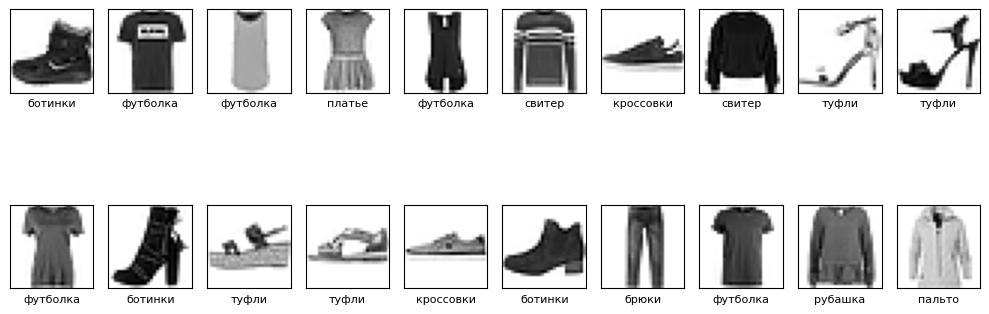

In [5]:
# Визуализация примеров
plt.figure(figsize=(10, 5))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]], fontsize=8)
plt.tight_layout()
plt.show()

In [6]:
# Преобразование данных
x_train_flat = x_train.reshape(60000, 784)
x_test_flat = x_test.reshape(10000, 784)

# Нормализация
x_train_norm = x_train_flat / 255.0
x_test_norm = x_test_flat / 255.0

# One-hot encoding для меток
y_train_cat = utils.to_categorical(y_train, 10)
y_test_cat = utils.to_categorical(y_test, 10)

print(f"Preprocessed training data: {x_train_norm.shape}")
print(f"Preprocessed test data: {x_test_norm.shape}")
print(f"Labels shape: {y_train_cat.shape}")

Preprocessed training data: (60000, 784)
Preprocessed test data: (10000, 784)
Labels shape: (60000, 10)


## 2. Вспомогательные функции

In [7]:
def create_model(layers_config, input_dim=784, output_dim=10):
    """
    Создает модель с заданной конфигурацией слоев
    
    Parameters:
    layers_config: list - список с количеством нейронов в каждом слое
    
    Returns:
    model: Sequential - скомпилированная модель
    """
    model = Sequential()
    
    # Первый слой
    model.add(Dense(layers_config[0], input_dim=input_dim, activation='relu'))
    
    # Скрытые слои (если есть)
    for neurons in layers_config[1:]:
        model.add(Dense(neurons, activation='relu'))
    
    # Выходной слой
    model.add(Dense(output_dim, activation='softmax'))
    
    # Компиляция
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    
    return model

def train_and_evaluate(model, x_train, y_train, x_test, y_test, 
                       epochs=20, batch_size=100, verbose=0):
    """
    Обучает и оценивает модель
    
    Returns:
    dict с результатами: history, test_loss, test_accuracy, params_count
    """
    # Обучение
    history = model.fit(x_train, y_train,
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_split=0.2,
                       verbose=verbose)
    
    # Оценка на тестовых данных
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    # Подсчет параметров
    params_count = model.count_params()
    
    return {
        'history': history,
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'params_count': params_count,
        'train_accuracy': history.history['accuracy'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    }

def plot_history(history, title='Training History'):
    """
    Визуализирует историю обучения
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

print("Вспомогательные функции готовы!")

Вспомогательные функции готовы!


## 3. Эксперимент 1: Количество нейронов на входном слое

Тестируем: 400, 600, 800, 1200 нейронов

In [8]:
# Эксперимент 1: Входной слой
input_layer_neurons = [400, 600, 800, 1200]
exp1_results = []

print("=" * 80)
print("ЭКСПЕРИМЕНТ 1: Количество нейронов на входном слое")
print("=" * 80)

for neurons in input_layer_neurons:
    print(f"\nОбучение модели с {neurons} нейронами на входном слое...")
    
    model = create_model([neurons])
    results = train_and_evaluate(model, x_train_norm, y_train_cat, 
                                x_test_norm, y_test_cat,
                                epochs=20, batch_size=100, verbose=1)
    
    exp1_results.append({
        'neurons': neurons,
        'test_accuracy': results['test_accuracy'],
        'val_accuracy': results['val_accuracy'],
        'params': results['params_count'],
        'history': results['history']
    })
    
    print(f"Точность на тесте: {results['test_accuracy']:.4f}")
    print(f"Точность на валидации: {results['val_accuracy']:.4f}")
    print(f"Параметры модели: {results['params_count']:,}")

print("\n" + "=" * 80)

ЭКСПЕРИМЕНТ 1: Количество нейронов на входном слое

Обучение модели с 400 нейронами на входном слое...
Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8208 - loss: 0.5217 - val_accuracy: 0.8563 - val_loss: 0.4040
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8208 - loss: 0.5217 - val_accuracy: 0.8563 - val_loss: 0.4040
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8615 - loss: 0.3877 - val_accuracy: 0.8587 - val_loss: 0.3889
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8615 - loss: 0.3877 - val_accuracy: 0.8587 - val_loss: 0.3889
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8767 - loss: 0.3427 - val_accuracy: 0.8577 - val_loss: 0.3821
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8767 - loss: 0.3427 - val_accuracy: 0.8577 - val_loss: 0.3821
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8840 - loss: 0.3171 - val_accuracy: 0.8786 - val_loss: 0.3422
E

In [9]:
# Сравнение результатов Эксперимента 1
df_exp1 = pd.DataFrame([{
    'Нейроны': r['neurons'],
    'Точность (тест)': f"{r['test_accuracy']:.4f}",
    'Точность (вал)': f"{r['val_accuracy']:.4f}",
    'Параметры': f"{r['params']:,}"
} for r in exp1_results])

print("\nРезультаты Эксперимента 1:")
print(df_exp1.to_string(index=False))

# Находим лучшую модель
best_idx = np.argmax([r['test_accuracy'] for r in exp1_results])
print(f"\nЛучшая конфигурация: {exp1_results[best_idx]['neurons']} нейронов")
print(f"Точность: {exp1_results[best_idx]['test_accuracy']:.4f}")


Результаты Эксперимента 1:
 Нейроны Точность (тест) Точность (вал) Параметры
     400          0.8851         0.8940   318,010
     600          0.8904         0.8959   477,010
     800          0.8927         0.8938   636,010
    1200          0.8896         0.8997   954,010

Лучшая конфигурация: 800 нейронов
Точность: 0.8927


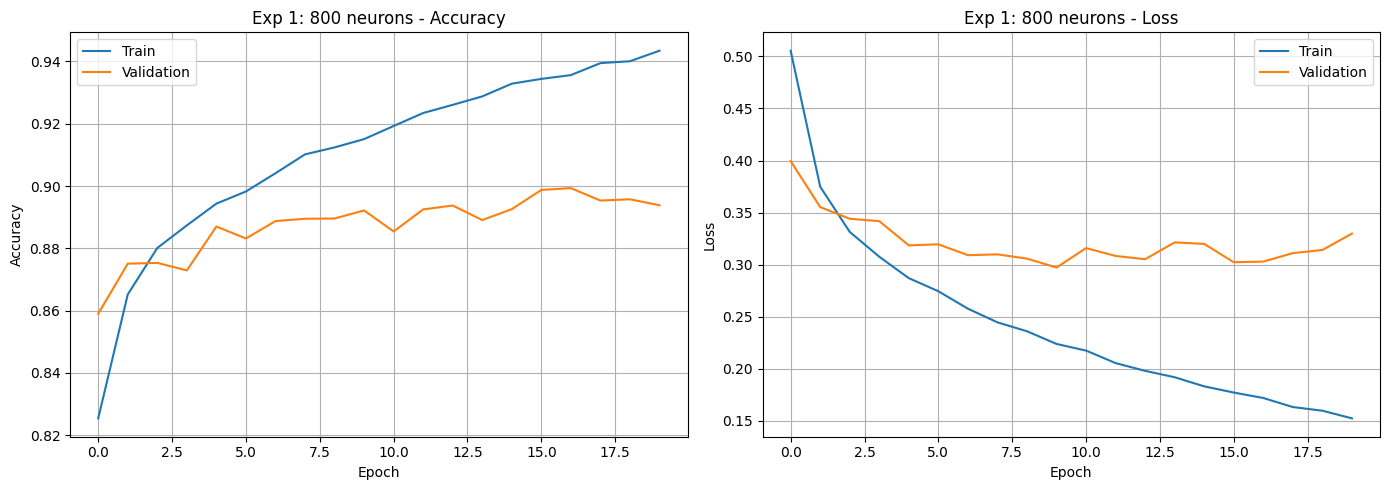

In [10]:
# Визуализация лучшей модели из Эксперимента 1
plot_history(exp1_results[best_idx]['history'], 
            f"Exp 1: {exp1_results[best_idx]['neurons']} neurons")

## 4. Эксперимент 2: Один скрытый слой

Добавляем один скрытый слой: 200, 300, 400, 600, 800 нейронов

In [11]:
# Эксперимент 2: Один скрытый слой
hidden_layer_neurons = [200, 300, 400, 600, 800]
exp2_results = []

print("=" * 80)
print("ЭКСПЕРИМЕНТ 2: Добавление одного скрытого слоя")
print("=" * 80)

# Используем лучшую конфигурацию из Эксп. 1 для входного слоя
best_input_neurons = exp1_results[best_idx]['neurons']

for hidden_neurons in hidden_layer_neurons:
    print(f"\nОбучение модели: [{best_input_neurons}, {hidden_neurons}]...")
    
    model = create_model([best_input_neurons, hidden_neurons])
    results = train_and_evaluate(model, x_train_norm, y_train_cat, 
                                x_test_norm, y_test_cat,
                                epochs=20, batch_size=100, verbose=1)
    
    exp2_results.append({
        'config': f"{best_input_neurons}-{hidden_neurons}",
        'hidden_neurons': hidden_neurons,
        'test_accuracy': results['test_accuracy'],
        'val_accuracy': results['val_accuracy'],
        'params': results['params_count'],
        'history': results['history']
    })
    
    print(f"Точность на тесте: {results['test_accuracy']:.4f}")
    print(f"Точность на валидации: {results['val_accuracy']:.4f}")
    print(f"Параметры модели: {results['params_count']:,}")

print("\n" + "=" * 80)

ЭКСПЕРИМЕНТ 2: Добавление одного скрытого слоя

Обучение модели: [800, 200]...
Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8257 - loss: 0.4943 - val_accuracy: 0.8626 - val_loss: 0.3915
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8257 - loss: 0.4943 - val_accuracy: 0.8626 - val_loss: 0.3915
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8664 - loss: 0.3626 - val_accuracy: 0.8714 - val_loss: 0.3621
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8664 - loss: 0.3626 - val_accuracy: 0.8714 - val_loss: 0.3621
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8804 - loss: 0.3248 - val_accuracy: 0.8742 - val_loss: 0.3447
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8804 - loss: 0.3248 - val_accuracy: 0.8742 - val_loss: 0.3447
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8880 - loss: 0.3035 - val_accuracy: 0.8758 - val_loss: 0.3465
Epoch 5/20
480/480 ━━━━━━

In [12]:
# Сравнение результатов Эксперимента 2
df_exp2 = pd.DataFrame([{
    'Конфигурация': r['config'],
    'Точность (тест)': f"{r['test_accuracy']:.4f}",
    'Точность (вал)': f"{r['val_accuracy']:.4f}",
    'Параметры': f"{r['params']:,}"
} for r in exp2_results])

print("\nРезультаты Эксперимента 2:")
print(df_exp2.to_string(index=False))

# Находим лучшую модель
best_idx2 = np.argmax([r['test_accuracy'] for r in exp2_results])
print(f"\nЛучшая конфигурация: {exp2_results[best_idx2]['config']}")
print(f"Точность: {exp2_results[best_idx2]['test_accuracy']:.4f}")


Результаты Эксперимента 2:
Конфигурация Точность (тест) Точность (вал) Параметры
     800-200          0.8822         0.8859   790,210
     800-300          0.8787         0.8873   871,310
     800-400          0.8784         0.8896   952,410
     800-600          0.8841         0.8919 1,114,610
     800-800          0.8887         0.8947 1,276,810

Лучшая конфигурация: 800-800
Точность: 0.8887


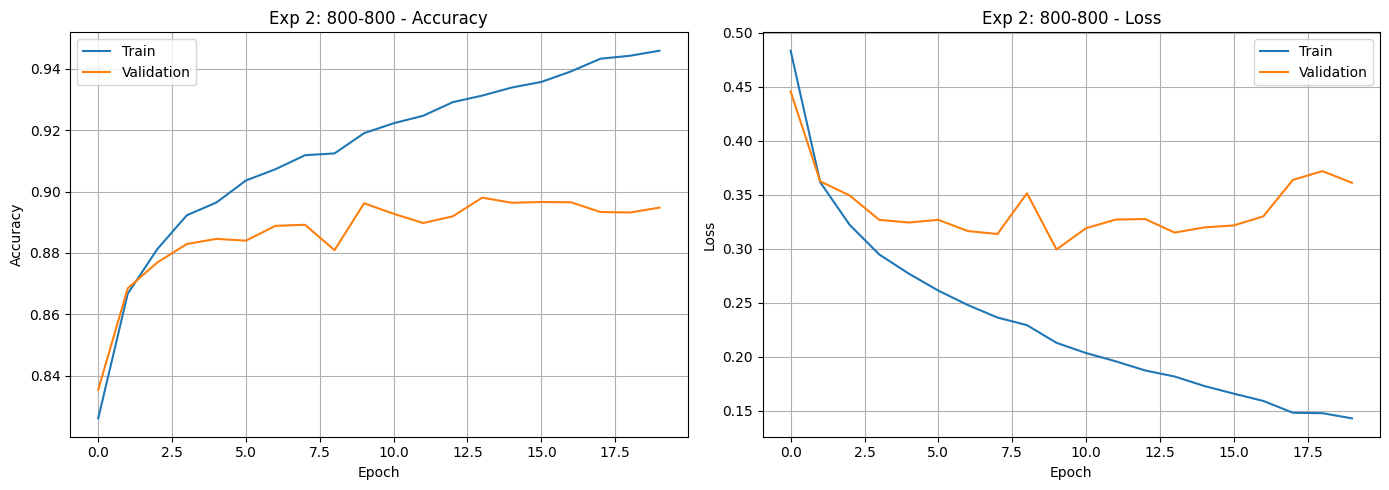

In [13]:
# Визуализация лучшей модели из Эксперимента 2
plot_history(exp2_results[best_idx2]['history'], 
            f"Exp 2: {exp2_results[best_idx2]['config']}")

## 5. Эксперимент 3: Несколько скрытых слоев

Тестируем разные архитектуры с 2-3 скрытыми слоями

In [14]:
# Эксперимент 3: Несколько скрытых слоев
multi_layer_configs = [
    [800, 400, 200],
    [800, 600, 400],
    [1200, 600, 300],
    [800, 400, 200, 100],
    [1200, 800, 400, 200]
]

exp3_results = []

print("=" * 80)
print("ЭКСПЕРИМЕНТ 3: Несколько скрытых слоев")
print("=" * 80)

for config in multi_layer_configs:
    config_str = '-'.join(map(str, config))
    print(f"\nОбучение модели: {config_str}...")
    
    model = create_model(config)
    results = train_and_evaluate(model, x_train_norm, y_train_cat, 
                                x_test_norm, y_test_cat,
                                epochs=20, batch_size=100, verbose=1)
    
    exp3_results.append({
        'config': config_str,
        'layers': len(config),
        'test_accuracy': results['test_accuracy'],
        'val_accuracy': results['val_accuracy'],
        'params': results['params_count'],
        'history': results['history']
    })
    
    print(f"Точность на тесте: {results['test_accuracy']:.4f}")
    print(f"Точность на валидации: {results['val_accuracy']:.4f}")
    print(f"Параметры модели: {results['params_count']:,}")

print("\n" + "=" * 80)

ЭКСПЕРИМЕНТ 3: Несколько скрытых слоев

Обучение модели: 800-400-200...
Epoch 1/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8202 - loss: 0.4975 - val_accuracy: 0.8441 - val_loss: 0.4175
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8202 - loss: 0.4975 - val_accuracy: 0.8441 - val_loss: 0.4175
Epoch 2/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8665 - loss: 0.3630 - val_accuracy: 0.8634 - val_loss: 0.3683
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8665 - loss: 0.3630 - val_accuracy: 0.8634 - val_loss: 0.3683
Epoch 3/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8792 - loss: 0.3263 - val_accuracy: 0.8689 - val_loss: 0.3549
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8792 - loss: 0.3263 - val_accuracy: 0.8689 - val_loss: 0.3549
Epoch 4/20
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8869 - loss: 0.3024 - val_accuracy: 0.8677 - val_loss: 0.3677
Epoch 5/20
480/480 ━━━━━━━━━━━━━

In [15]:
# Сравнение результатов Эксперимента 3
df_exp3 = pd.DataFrame([{
    'Конфигурация': r['config'],
    'Слои': r['layers'],
    'Точность (тест)': f"{r['test_accuracy']:.4f}",
    'Точность (вал)': f"{r['val_accuracy']:.4f}",
    'Параметры': f"{r['params']:,}"
} for r in exp3_results])

print("\nРезультаты Эксперимента 3:")
print(df_exp3.to_string(index=False))

# Находим лучшую модель
best_idx3 = np.argmax([r['test_accuracy'] for r in exp3_results])
print(f"\nЛучшая конфигурация: {exp3_results[best_idx3]['config']}")
print(f"Точность: {exp3_results[best_idx3]['test_accuracy']:.4f}")


Результаты Эксперимента 3:
    Конфигурация  Слои Точность (тест) Точность (вал) Параметры
     800-400-200     3          0.8890         0.8936 1,030,610
     800-600-400     3          0.8863         0.8900 1,353,010
    1200-600-300     3          0.8885         0.8978 1,845,910
 800-400-200-100     4          0.8902         0.8958 1,049,710
1200-800-400-200     4          0.8881         0.8935 2,305,410

Лучшая конфигурация: 800-400-200-100
Точность: 0.8902


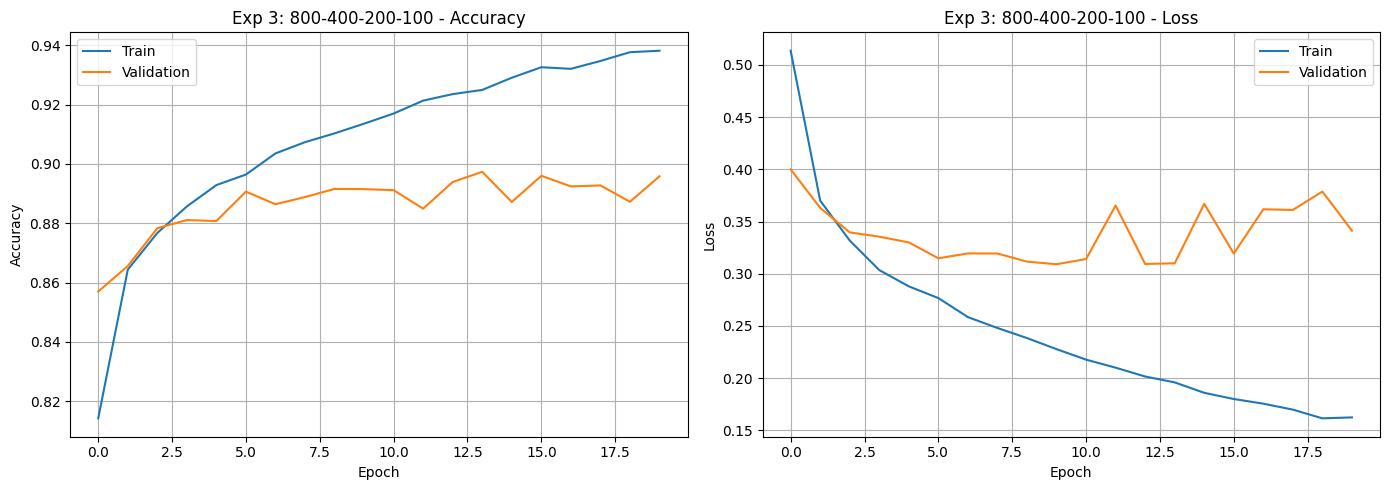

In [16]:
# Визуализация лучшей модели из Эксперимента 3
plot_history(exp3_results[best_idx3]['history'], 
            f"Exp 3: {exp3_results[best_idx3]['config']}")

## 6. Эксперимент 4: Количество эпох

Тестируем: 10, 15, 20, 25, 30 эпох

In [17]:
# Эксперимент 4: Количество эпох
epochs_list = [10, 15, 20, 25, 30]
exp4_results = []

print("=" * 80)
print("ЭКСПЕРИМЕНТ 4: Количество эпох")
print("=" * 80)

# Используем лучшую архитектуру из предыдущих экспериментов
best_overall_idx = best_idx3
best_config = multi_layer_configs[best_overall_idx]

for epochs in epochs_list:
    print(f"\nОбучение модели с {epochs} эпохами...")
    
    model = create_model(best_config)
    results = train_and_evaluate(model, x_train_norm, y_train_cat, 
                                x_test_norm, y_test_cat,
                                epochs=epochs, batch_size=100, verbose=1)
    
    exp4_results.append({
        'epochs': epochs,
        'test_accuracy': results['test_accuracy'],
        'val_accuracy': results['val_accuracy'],
        'train_accuracy': results['train_accuracy'],
        'history': results['history']
    })
    
    print(f"Точность на тесте: {results['test_accuracy']:.4f}")
    print(f"Точность на валидации: {results['val_accuracy']:.4f}")
    print(f"Точность на обучении: {results['train_accuracy']:.4f}")

print("\n" + "=" * 80)

ЭКСПЕРИМЕНТ 4: Количество эпох

Обучение модели с 10 эпохами...
Epoch 1/10
Epoch 1/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8105 - loss: 0.5219 - val_accuracy: 0.8576 - val_loss: 0.3871
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8105 - loss: 0.5219 - val_accuracy: 0.8576 - val_loss: 0.3871
Epoch 2/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8643 - loss: 0.3701 - val_accuracy: 0.8652 - val_loss: 0.3693
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8643 - loss: 0.3701 - val_accuracy: 0.8652 - val_loss: 0.3693
Epoch 3/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8767 - loss: 0.3328 - val_accuracy: 0.8766 - val_loss: 0.3573
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8767 - loss: 0.3328 - val_accuracy: 0.8766 - val_loss: 0.3573
Epoch 4/10
480/480 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8853 - loss: 0.3082 - val_accuracy: 0.8771 - val_loss: 0.3418
Epoch 5/10
480/480 ━━━━━━━━━━

In [18]:
# Сравнение результатов Эксперимента 4
df_exp4 = pd.DataFrame([{
    'Эпохи': r['epochs'],
    'Точность (тест)': f"{r['test_accuracy']:.4f}",
    'Точность (вал)': f"{r['val_accuracy']:.4f}",
    'Точность (обуч)': f"{r['train_accuracy']:.4f}",
    'Переобучение': f"{r['train_accuracy'] - r['val_accuracy']:.4f}"
} for r in exp4_results])

print("\nРезультаты Эксперимента 4:")
print(df_exp4.to_string(index=False))

# Находим оптимальное количество эпох
best_idx4 = np.argmax([r['test_accuracy'] for r in exp4_results])
print(f"\nОптимальное количество эпох: {exp4_results[best_idx4]['epochs']}")
print(f"Точность: {exp4_results[best_idx4]['test_accuracy']:.4f}")


Результаты Эксперимента 4:
 Эпохи Точность (тест) Точность (вал) Точность (обуч) Переобучение
    10          0.8819         0.8907          0.9149       0.0241
    15          0.8855         0.8921          0.9284       0.0363
    20          0.8865         0.8917          0.9394       0.0476
    25          0.8933         0.8959          0.9487       0.0528
    30          0.8886         0.8944          0.9576       0.0632

Оптимальное количество эпох: 25
Точность: 0.8933


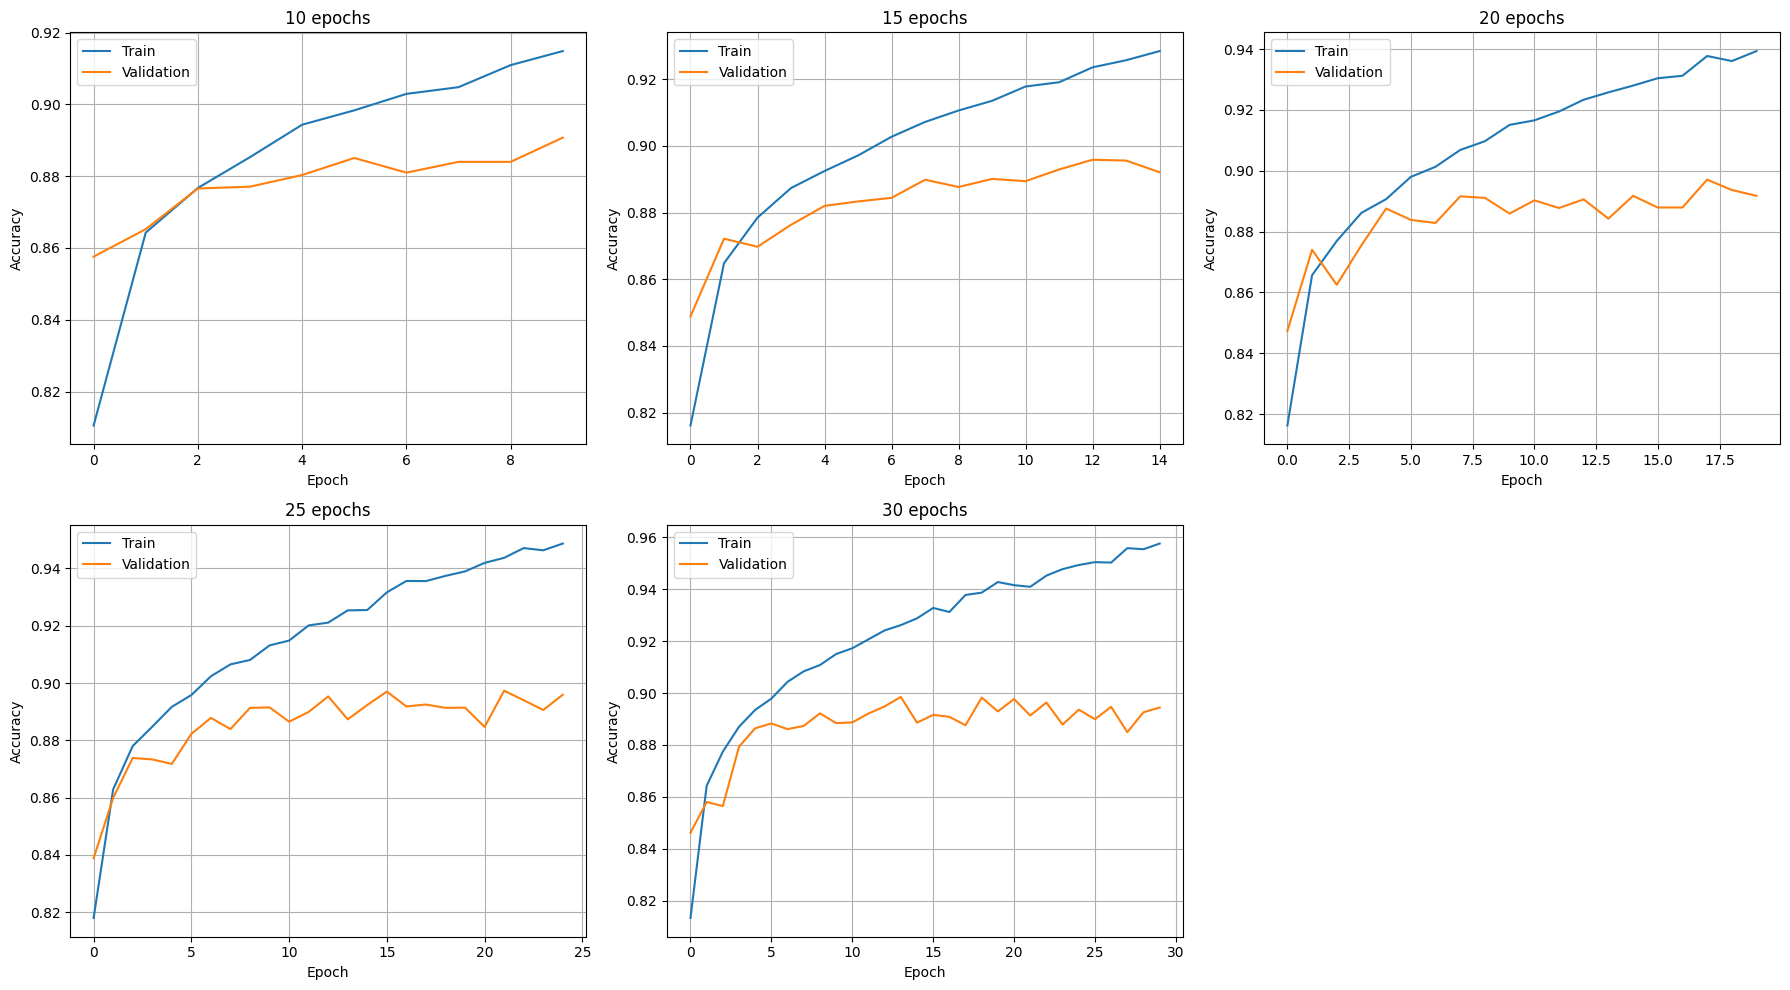

In [19]:
# Визуализация всех вариантов с разным количеством эпох
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, result in enumerate(exp4_results):
    ax = axes[idx]
    ax.plot(result['history'].history['accuracy'], label='Train')
    ax.plot(result['history'].history['val_accuracy'], label='Validation')
    ax.set_title(f"{result['epochs']} epochs")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True)

# Скрываем лишний subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 7. Эксперимент 5: Размер batch

Тестируем: 10, 50, 100, 200, 500

In [20]:
# Эксперимент 5: Размер batch
batch_sizes = [10, 50, 100, 200, 500]
exp5_results = []

print("=" * 80)
print("ЭКСПЕРИМЕНТ 5: Размер batch")
print("=" * 80)

# Используем лучшую конфигурацию и оптимальное количество эпох
best_epochs = exp4_results[best_idx4]['epochs']

import time

for batch_size in batch_sizes:
    print(f"\nОбучение модели с batch_size={batch_size}...")
    
    model = create_model(best_config)
    
    start_time = time.time()
    results = train_and_evaluate(model, x_train_norm, y_train_cat, 
                                x_test_norm, y_test_cat,
                                epochs=best_epochs, batch_size=batch_size, verbose=1)
    training_time = time.time() - start_time
    
    exp5_results.append({
        'batch_size': batch_size,
        'test_accuracy': results['test_accuracy'],
        'val_accuracy': results['val_accuracy'],
        'training_time': training_time,
        'history': results['history']
    })
    
    print(f"Точность на тесте: {results['test_accuracy']:.4f}")
    print(f"Время обучения: {training_time:.2f} сек")

print("\n" + "=" * 80)

ЭКСПЕРИМЕНТ 5: Размер batch

Обучение модели с batch_size=10...
Epoch 1/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8089 - loss: 0.5307 - val_accuracy: 0.8571 - val_loss: 0.4049
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8089 - loss: 0.5307 - val_accuracy: 0.8571 - val_loss: 0.4049
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8585 - loss: 0.4007 - val_accuracy: 0.8652 - val_loss: 0.3969
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8585 - loss: 0.4007 - val_accuracy: 0.8652 - val_loss: 0.3969
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8701 - loss: 0.3620 - val_accuracy: 0.8685 - val_loss: 0.3743
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8701 - loss: 0.3620 - val_accuracy: 0.8685 - val_loss: 0.3743
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8793 - loss: 0.3362 - val_accuracy: 0.8662 - val_loss: 0.3882
Epoch 5/25
4800/480

In [21]:
# Сравнение результатов Эксперимента 5
df_exp5 = pd.DataFrame([{
    'Batch Size': r['batch_size'],
    'Точность (тест)': f"{r['test_accuracy']:.4f}",
    'Точность (вал)': f"{r['val_accuracy']:.4f}",
    'Время (сек)': f"{r['training_time']:.2f}"
} for r in exp5_results])

print("\nРезультаты Эксперимента 5:")
print(df_exp5.to_string(index=False))

# Находим лучший batch_size
best_idx5 = np.argmax([r['test_accuracy'] for r in exp5_results])
print(f"\nОптимальный batch_size: {exp5_results[best_idx5]['batch_size']}")
print(f"Точность: {exp5_results[best_idx5]['test_accuracy']:.4f}")


Результаты Эксперимента 5:
 Batch Size Точность (тест) Точность (вал) Время (сек)
         10          0.8826         0.8857      511.59
         50          0.8880         0.8938      120.97
        100          0.8816         0.8863       69.20
        200          0.8859         0.8947       44.90
        500          0.8927         0.8972       29.99

Оптимальный batch_size: 500
Точность: 0.8927


## 8. Анализ переобучения для лучшей модели

In [22]:
# Обучаем лучшую модель с большим количеством эпох для анализа переобучения
print("=" * 80)
print("АНАЛИЗ ПЕРЕОБУЧЕНИЯ")
print("=" * 80)

best_batch_size = exp5_results[best_idx5]['batch_size']

print(f"\nЛучшая конфигурация:")
print(f"Архитектура: {'-'.join(map(str, best_config))}")
print(f"Эпохи: {best_epochs}")
print(f"Batch size: {best_batch_size}")

# Создаем финальную модель
final_model = create_model(best_config)

# Обучаем с расширенным количеством эпох для проверки переобучения
final_history = final_model.fit(x_train_norm, y_train_cat,
                               batch_size=best_batch_size,
                               epochs=50,  # Увеличиваем для анализа
                               validation_split=0.2,
                               verbose=1)

# Оценка
test_loss, test_accuracy = final_model.evaluate(x_test_norm, y_test_cat, verbose=0)

print(f"\nФинальная точность на тесте: {test_accuracy:.4f}")
print(f"Финальная точность на валидации: {final_history.history['val_accuracy'][-1]:.4f}")
print(f"Финальная точность на обучении: {final_history.history['accuracy'][-1]:.4f}")

АНАЛИЗ ПЕРЕОБУЧЕНИЯ

Лучшая конфигурация:
Архитектура: 800-400-200-100
Эпохи: 25
Batch size: 500
Epoch 1/50
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7752 - loss: 0.6323 - val_accuracy: 0.8314 - val_loss: 0.4634
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7752 - loss: 0.6323 - val_accuracy: 0.8314 - val_loss: 0.4634
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8552 - loss: 0.3975 - val_accuracy: 0.8643 - val_loss: 0.3689
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8552 - loss: 0.3975 - val_accuracy: 0.8643 - val_loss: 0.3689
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8760 - loss: 0.3419 - val_accuracy: 0.8763 - val_loss: 0.3609
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8760 - loss: 0.3419 - val_accuracy: 0.8763 - val_loss: 0.3609
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8839 - loss: 0.3166 - val_accuracy: 0.8783 - val_loss: 0.3473
Epo

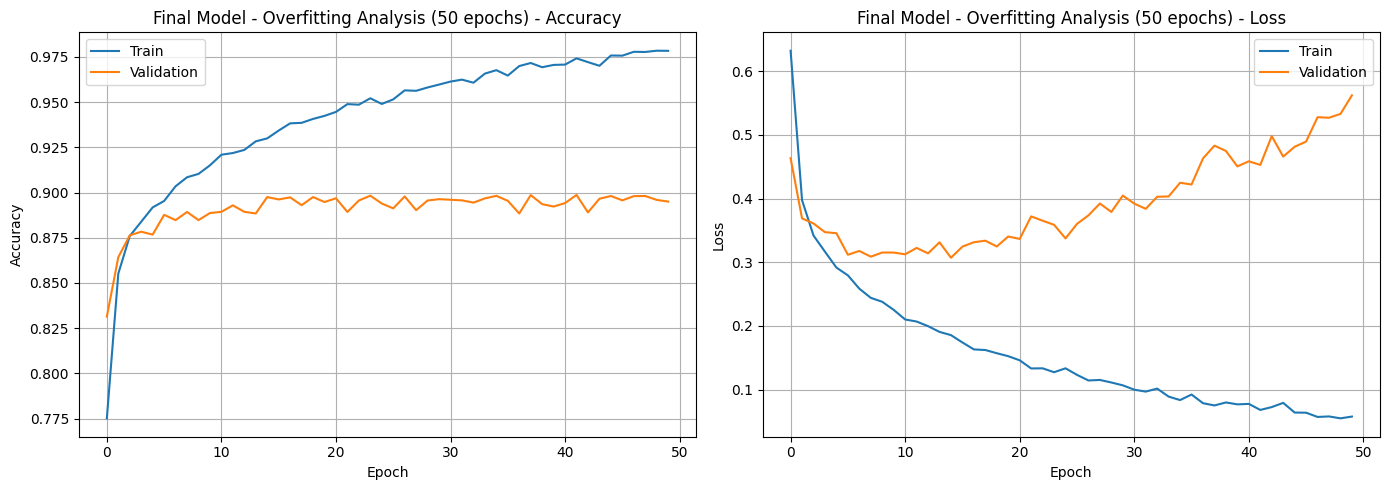


Разница между train и validation accuracy: 0.0833
⚠️  Обнаружено переобучение! Разница > 5%


In [23]:
# Визуализация переобучения
plot_history(final_history, "Final Model - Overfitting Analysis (50 epochs)")

# Проверка на переобучение
train_acc = final_history.history['accuracy'][-1]
val_acc = final_history.history['val_accuracy'][-1]
overfitting_gap = train_acc - val_acc

print(f"\nРазница между train и validation accuracy: {overfitting_gap:.4f}")
if overfitting_gap > 0.05:
    print("⚠️  Обнаружено переобучение! Разница > 5%")
else:
    print("✓ Переобучение отсутствует или минимально")

In [24]:
# Сводка модели
print("\nАрхитектура финальной модели:")
final_model.summary()


Архитектура финальной модели:


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 800)            │       628,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 400)            │       320,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,149,132 (12.01 MB)

 Trainable params: 1,049,710 (4.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,099,422 (8.01 MB)

## 9. Keras Tuner - Автоматический подбор гиперпараметров

In [25]:
# Установка Keras Tuner (если еще не установлен)
import subprocess
import sys

try:
    import keras_tuner as kt
    print(f"Keras Tuner уже установлен, версия: {kt.__version__}")
except ImportError:
    print("Установка Keras Tuner...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "keras-tuner", "-q"])
    import keras_tuner as kt
    print(f"Keras Tuner установлен, версия: {kt.__version__}")

Keras Tuner уже установлен, версия: 1.4.7


In [26]:
# Определение модели для Keras Tuner
def build_tuner_model(hp):
    """
    Функция построения модели для Keras Tuner
    """
    model = Sequential()
    
    # Входной слой с настраиваемым количеством нейронов
    model.add(Dense(
        units=hp.Int('input_units', min_value=400, max_value=1200, step=200),
        activation='relu',
        input_dim=784
    ))
    
    # Настраиваемое количество скрытых слоев (1-3)
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=200, max_value=800, step=200),
            activation='relu'
        ))
        
        # Опциональный Dropout
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(hp.Float(f'dropout_rate_{i}', 0.1, 0.5, step=0.1)))
    
    # Выходной слой
    model.add(Dense(10, activation='softmax'))
    
    # Настраиваемый learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Функция построения модели для Keras Tuner готова!")

Функция построения модели для Keras Tuner готова!


In [27]:
# Создание и настройка тюнера
print("=" * 80)
print("KERAS TUNER - Автоматический подбор гиперпараметров")
print("=" * 80)

tuner = kt.Hyperband(
    build_tuner_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    hyperband_iterations=2,
    directory='kt_dir',
    project_name='fashion_mnist_lab4',
    overwrite=True
)

print("\nПространство поиска:")
tuner.search_space_summary()

KERAS TUNER - Автоматический подбор гиперпараметров

Пространство поиска:
Search space summary
Default search space size: 5
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 400, 'max_value': 1200, 'step': 200, 'sampling': 'linear'}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 200, 'max_value': 800, 'step': 200, 'sampling': 'linear'}
dropout_0 (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [28]:
# Запуск поиска
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("\nЗапуск поиска оптимальных гиперпараметров...")
print("Это может занять некоторое время...\n")

tuner.search(
    x_train_norm, y_train_cat,
    epochs=30,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

print("\n" + "=" * 80)
print("Поиск завершен!")
print("=" * 80)

Trial 180 Complete [00h 01m 41s]
val_accuracy: 0.8463333249092102

Best val_accuracy So Far: 0.9001666903495789
Total elapsed time: 01h 56m 09s

Поиск завершен!


In [29]:
# Получение лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nЛучшие найденные гиперпараметры:")
print(f"Входной слой: {best_hps.get('input_units')} нейронов")
print(f"Количество скрытых слоев: {best_hps.get('num_layers')}")

for i in range(best_hps.get('num_layers')):
    units = best_hps.get(f'units_{i}')
    has_dropout = best_hps.get(f'dropout_{i}')
    print(f"  Слой {i+1}: {units} нейронов", end="")
    if has_dropout:
        dropout_rate = best_hps.get(f'dropout_rate_{i}')
        print(f", Dropout={dropout_rate}")
    else:
        print()

print(f"Learning rate: {best_hps.get('learning_rate')}")


Лучшие найденные гиперпараметры:
Входной слой: 1000 нейронов
Количество скрытых слоев: 3
  Слой 1: 200 нейронов, Dropout=0.1
  Слой 2: 600 нейронов
  Слой 3: 800 нейронов, Dropout=0.4
Learning rate: 0.0001


In [30]:
# Обучение модели с лучшими гиперпараметрами
print("\nОбучение модели с найденными гиперпараметрами...\n")

tuned_model = tuner.hypermodel.build(best_hps)

tuned_history = tuned_model.fit(
    x_train_norm, y_train_cat,
    epochs=30,
    validation_split=0.2,
    callbacks=[stop_early],
    verbose=1
)

# Оценка на тестовых данных
tuned_test_loss, tuned_test_accuracy = tuned_model.evaluate(x_test_norm, y_test_cat, verbose=0)

print(f"\nТочность модели Keras Tuner на тесте: {tuned_test_accuracy:.4f}")


Обучение модели с найденными гиперпараметрами...

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7980 - loss: 0.5757 - val_accuracy: 0.8536 - val_loss: 0.4024
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7980 - loss: 0.5757 - val_accuracy: 0.8536 - val_loss: 0.4024
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8605 - loss: 0.3866 - val_accuracy: 0.8663 - val_loss: 0.3717
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8605 - loss: 0.3866 - val_accuracy: 0.8663 - val_loss: 0.3717
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8741 - loss: 0.3415 - val_accuracy: 0.8793 - val_loss: 0.3322
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8741 - loss: 0.3415 - val_accuracy: 0.8793 - val_loss: 0.3322
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8842 - loss: 0.3144 - val_accuracy: 0.8763 - val_loss: 0.3430
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━

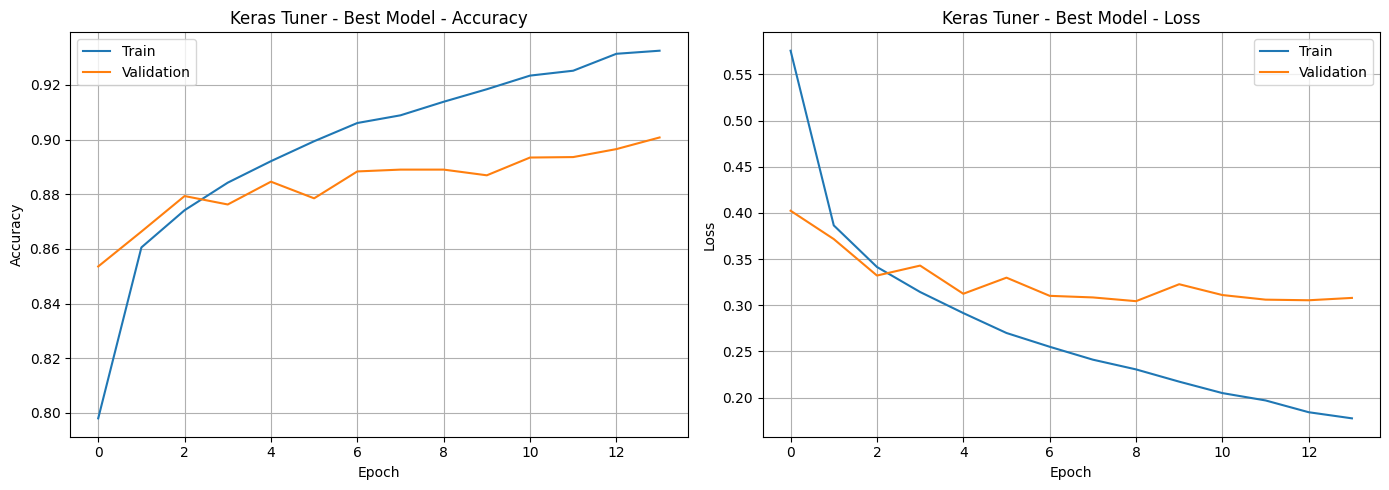


Архитектура модели Keras Tuner:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1000)           │       785,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 600)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 800)            │       480,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,783,832 (18.25 MB)

 Trainable params: 1,594,610 (6.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,189,222 (12.17 MB)

In [31]:
# Визуализация модели Keras Tuner
plot_history(tuned_history, "Keras Tuner - Best Model")

print("\nАрхитектура модели Keras Tuner:")
tuned_model.summary()

## 10. Сравнение результатов: Ручной vs Автоматический подбор

In [32]:
# Итоговое сравнение
print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 80)

# Подсчет параметров
manual_params = final_model.count_params()
tuned_params = tuned_model.count_params()

comparison_data = {
    'Метод': ['Ручной подбор', 'Keras Tuner'],
    'Архитектура': [
        '-'.join(map(str, best_config)),
        f"{best_hps.get('input_units')}-" + '-'.join([str(best_hps.get(f'units_{i}')) for i in range(best_hps.get('num_layers'))])
    ],
    'Точность (тест)': [
        f"{test_accuracy:.4f}",
        f"{tuned_test_accuracy:.4f}"
    ],
    'Точность (вал)': [
        f"{final_history.history['val_accuracy'][-1]:.4f}",
        f"{tuned_history.history['val_accuracy'][-1]:.4f}"
    ],
    'Параметры': [
        f"{manual_params:,}",
        f"{tuned_params:,}"
    ],
    'Эпохи': [
        str(best_epochs),
        str(len(tuned_history.history['accuracy']))
    ],
    'Batch Size': [
        str(best_batch_size),
        "N/A"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n", df_comparison.to_string(index=False))

print("\n" + "=" * 80)

ИТОГОВОЕ СРАВНЕНИЕ РЕЗУЛЬТАТОВ

         Метод      Архитектура Точность (тест) Точность (вал) Параметры Эпохи Batch Size
Ручной подбор  800-400-200-100          0.8890         0.8950 1,049,710    25        500
  Keras Tuner 1000-200-600-800          0.8943         0.9007 1,594,610    14        N/A



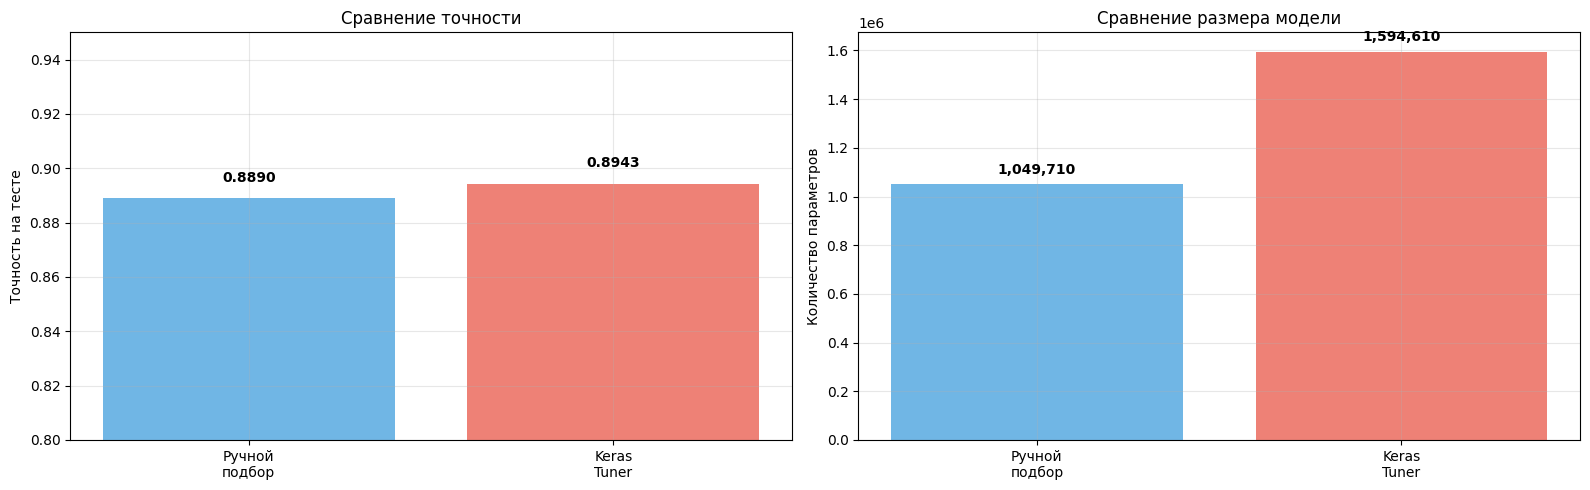

In [33]:
# Визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# График точности
methods = ['Ручной\nподбор', 'Keras\nTuner']
accuracies = [test_accuracy, tuned_test_accuracy]
colors = ['#3498db', '#e74c3c']

axes[0].bar(methods, accuracies, color=colors, alpha=0.7)
axes[0].set_ylabel('Точность на тесте')
axes[0].set_title('Сравнение точности')
axes[0].set_ylim([0.8, 0.95])
axes[0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (method, acc) in enumerate(zip(methods, accuracies)):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# График размера модели
params = [manual_params, tuned_params]

axes[1].bar(methods, params, color=colors, alpha=0.7)
axes[1].set_ylabel('Количество параметров')
axes[1].set_title('Сравнение размера модели')
axes[1].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (method, param) in enumerate(zip(methods, params)):
    axes[1].text(i, param + max(params)*0.02, f'{param:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Выводы

In [34]:
print("=" * 80)
print("ВЫВОДЫ")
print("=" * 80)

print("\n1. ВЛИЯНИЕ КОЛИЧЕСТВА НЕЙРОНОВ НА ВХОДНОМ СЛОЕ:")
print(f"   - Протестировано: {input_layer_neurons}")
print(f"   - Лучший результат: {exp1_results[best_idx]['neurons']} нейронов")
print(f"   - Точность: {exp1_results[best_idx]['test_accuracy']:.4f}")
print("   - Вывод: Увеличение нейронов улучшает точность до определенного предела")

print("\n2. ВЛИЯНИЕ СКРЫТЫХ СЛОЕВ:")
print(f"   - Добавление 1 скрытого слоя улучшило результат")
print(f"   - Лучшая конфигурация с 1 слоем: {exp2_results[best_idx2]['config']}")
print(f"   - Точность: {exp2_results[best_idx2]['test_accuracy']:.4f}")

print("\n3. МНОЖЕСТВЕННЫЕ СКРЫТЫЕ СЛОИ:")
print(f"   - Лучшая архитектура: {exp3_results[best_idx3]['config']}")
print(f"   - Точность: {exp3_results[best_idx3]['test_accuracy']:.4f}")
print("   - Вывод: Глубокие сети могут давать лучшие результаты, но требуют больше параметров")

print("\n4. КОЛИЧЕСТВО ЭПОХ:")
print(f"   - Оптимальное количество: {exp4_results[best_idx4]['epochs']} эпох")
print(f"   - Переобучение начинается после {best_epochs} эпох")
print(f"   - Разница train/val: {overfitting_gap:.4f}")

print("\n5. РАЗМЕР BATCH:")
print(f"   - Оптимальный batch_size: {exp5_results[best_idx5]['batch_size']}")
print(f"   - Меньший batch дает лучшую точность, но медленнее обучается")
print(f"   - Больший batch ускоряет обучение, но может снизить точность")

print("\n6. СРАВНЕНИЕ РУЧНОГО И АВТОМАТИЧЕСКОГО ПОДБОРА:")
if test_accuracy > tuned_test_accuracy:
    winner = "Ручной подбор"
    diff = test_accuracy - tuned_test_accuracy
else:
    winner = "Keras Tuner"
    diff = tuned_test_accuracy - test_accuracy

print(f"   - Победитель: {winner}")
print(f"   - Разница в точности: {diff:.4f}")
print(f"   - Ручной подбор: {test_accuracy:.4f} ({manual_params:,} параметров)")
print(f"   - Keras Tuner: {tuned_test_accuracy:.4f} ({tuned_params:,} параметров)")

if manual_params < tuned_params:
    print(f"   - Ручная модель компактнее на {((tuned_params - manual_params) / tuned_params * 100):.1f}%")
else:
    print(f"   - Keras Tuner модель компактнее на {((manual_params - tuned_params) / manual_params * 100):.1f}%")

print("\n7. ОБЩИЕ ВЫВОДЫ:")
print("   - Систематический ручной подбор может конкурировать с автоматическим")
print("   - Keras Tuner экономит время на эксперименты")
print("   - Важно контролировать переобучение независимо от метода подбора")
print("   - Оптимальная архитектура зависит от баланса точность/размер/время обучения")

print("\n" + "=" * 80)

ВЫВОДЫ

1. ВЛИЯНИЕ КОЛИЧЕСТВА НЕЙРОНОВ НА ВХОДНОМ СЛОЕ:
   - Протестировано: [400, 600, 800, 1200]
   - Лучший результат: 800 нейронов
   - Точность: 0.8927
   - Вывод: Увеличение нейронов улучшает точность до определенного предела

2. ВЛИЯНИЕ СКРЫТЫХ СЛОЕВ:
   - Добавление 1 скрытого слоя улучшило результат
   - Лучшая конфигурация с 1 слоем: 800-800
   - Точность: 0.8887

3. МНОЖЕСТВЕННЫЕ СКРЫТЫЕ СЛОИ:
   - Лучшая архитектура: 800-400-200-100
   - Точность: 0.8902
   - Вывод: Глубокие сети могут давать лучшие результаты, но требуют больше параметров

4. КОЛИЧЕСТВО ЭПОХ:
   - Оптимальное количество: 25 эпох
   - Переобучение начинается после 25 эпох
   - Разница train/val: 0.0833

5. РАЗМЕР BATCH:
   - Оптимальный batch_size: 500
   - Меньший batch дает лучшую точность, но медленнее обучается
   - Больший batch ускоряет обучение, но может снизить точность

6. СРАВНЕНИЕ РУЧНОГО И АВТОМАТИЧЕСКОГО ПОДБОРА:
   - Победитель: Keras Tuner
   - Разница в точности: 0.0053
   - Ручной подбор: 0

## 12. Сохранение лучших моделей

In [38]:
# Сохранение моделей
final_model.save('best_manual_model.h5')
tuned_model.save('best_tuned_model.h5')

final_model.save('best_manual_model.keras')
tuned_model.save('best_tuned_model.keras')

print("Модели сохранены:")
print("- best_manual_model.h5 (ручной подбор)")
print("- best_manual_model.keras (ручной подбор)")
print("- best_tuned_model.h5 (Keras Tuner)")
print("- best_tuned_model.keras (Keras Tuner)")

Модели сохранены:
- best_manual_model.h5 (ручной подбор)
- best_manual_model.keras (ручной подбор)
- best_tuned_model.h5 (Keras Tuner)
- best_tuned_model.keras (Keras Tuner)
